In [1]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2022-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-06-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "AAPL"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["ID", "Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


      ID       Date Company Type        Open        High         Low  \
226  226 2023-05-25    AAPL  ACT  172.410004  173.899994  171.690002   
227  227 2023-05-26    AAPL  ACT  173.320007  175.770004  173.110001   
228  228 2023-05-30    AAPL  ACT  176.960007  178.990005  176.570007   
229  229 2023-05-31    AAPL  ACT  177.330002  179.350006  176.759995   
230  230 2023-06-01    AAPL  ACT  177.699997  180.119995  176.929993   

          Close    Volume  
226  172.990005  56058300  
227  175.429993  54835000  
228  177.300003  55964400  
229  177.250000  99625300  
230  180.089996  68901800  


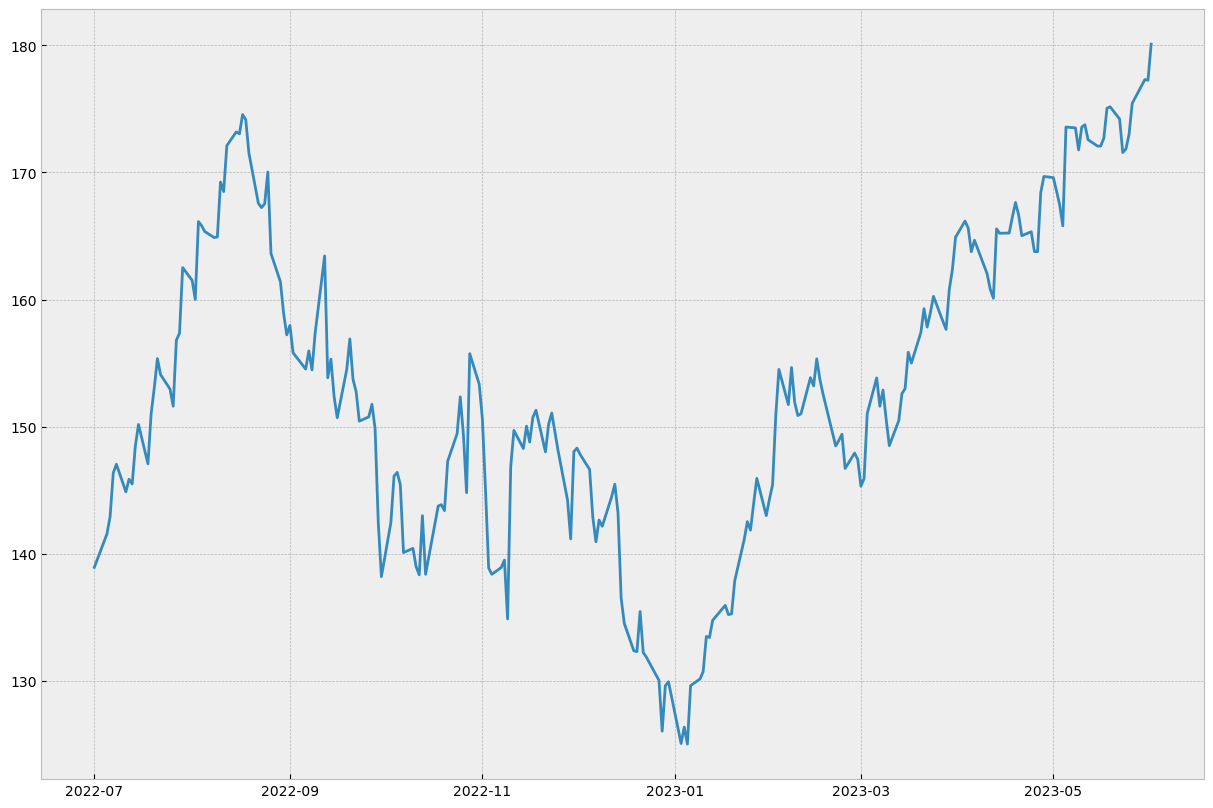

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

In [3]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Download stock data
#stock_data = yf.download('GOOG', start='2016-01-01', end='2023-07-01')

# Extract closing prices
close_prices = data['Close']
values = close_prices.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

# Prepare training data
training_data_len = math.ceil(len(values) * 0.8)
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
print(close_prices)

0      138.929993
1      141.559998
2      142.919998
3      146.350006
4      147.039993
          ...    
226    172.990005
227    175.429993
228    177.300003
229    177.250000
230    180.089996
Name: Close, Length: 231, dtype: float64


In [5]:
# Build and train the model
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
125/125 [==============================] - 7s 20ms/step - loss: 0.0125
Epoch 2/3
125/125 [==============================] - 2s 20ms/step - loss: 0.0092
Epoch 3/3
125/125 [==============================] - 2s 20ms/step - loss: 0.0076


In [6]:
# Prepare test data for predictions
test_data = scaled_data[training_data_len-60:, :]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [7]:
# Generate predictions for the future
future_periods = 30
x_future = x_test[-1]  # Use the last available sequence as the starting point

future_predictions = []
for _ in range(future_periods):
    x_future = np.reshape(x_future, (1, x_future.shape[0], 1))
    future_prediction = model.predict(x_future)
    future_predictions.append(future_prediction[0, 0])
    x_future = np.append(x_future[0][1:], future_prediction)

1/1 [==============================] - 0s 30ms/step


In [8]:
# Vorhersagen für die nächsten 30 Tage erhalten
predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Flatten the predictions
predictions_flat = predictions.flatten()

# Daten für die nächsten 30 Tage generieren
future_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Close': predictions_flat  # use flattened predictions here
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions], ignore_index=True)


In [9]:
print(data_extended)

      ID       Date Company Type        Open        High         Low  \
0    0.0 2022-07-01    AAPL  ACT  136.039993  139.039993  135.660004   
1    1.0 2022-07-05    AAPL  ACT  137.770004  141.610001  136.929993   
2    2.0 2022-07-06    AAPL  ACT  141.350006  144.119995  141.080002   
3    3.0 2022-07-07    AAPL  ACT  143.289993  146.550003  143.279999   
4    4.0 2022-07-08    AAPL  ACT  145.259995  147.550003  145.000000   
..   ...        ...     ...  ...         ...         ...         ...   
256  NaN 2023-06-27     NaN  NaN         NaN         NaN         NaN   
257  NaN 2023-06-28     NaN  NaN         NaN         NaN         NaN   
258  NaN 2023-06-29     NaN  NaN         NaN         NaN         NaN   
259  NaN 2023-06-30     NaN  NaN         NaN         NaN         NaN   
260  NaN 2023-07-01     NaN  NaN         NaN         NaN         NaN   

          Close      Volume  
0    138.929993  71051600.0  
1    141.559998  73353800.0  
2    142.919998  74064300.0  
3    146.350006

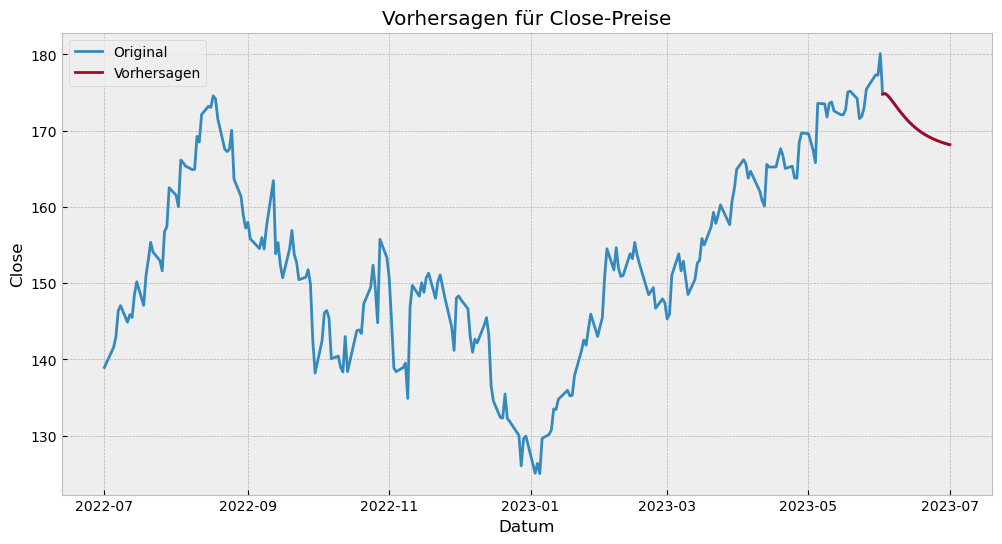

In [10]:
# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(data_extended['Date'], data_extended['Close'], label='Original')
plt.plot(data_extended['Date'].tail(30), data_extended['Close'].tail(30), label='Vorhersagen')
plt.xlabel('Datum')
plt.ylabel('Close')
plt.title('Vorhersagen für Close-Preise')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)


# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# DataFrame bearbeiten
company = data.loc[0]['Company']
#data_extended['Forecast_Date'] = data_extended['Date'].iloc[-1]
data_extended['Type'] = data_extended['High'].apply(lambda x: 'LSTM' if np.isnan(x) else 'Act')
data_extended.loc[data_extended['Type'] == 'LSTM', 'Forecast_Date'] = end_date
data_extended['Company'] = company
#data_extended['Key'] = data_extended['Company'] + '_' + data_extended['Date'].astype(str) + '_' + data_extended['Type']

# Auslesen der Tabelle aus der SQL Server-Datenbank
query = "SELECT * FROM stock_data_forecast WHERE Type IN ('LSTM')"
exists_df = pd.read_sql(query, cnxn)

# Zusammenführen der beiden DataFrames
combined_df = pd.concat([exists_df, data_extended])

# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Date', 'Company', 'Type'], keep='first')

# Key einbinden
combined_df['Key'] = data_extended['Company'] + '_' + data_extended['Date'].astype(str) + '_' + data_extended['Type']

# Schreiben des aktualisierten DataFrames in die SQL Server-Tabelle
combined_df.to_sql('stock_data_forecast', con=engine, if_exists='replace', index=False)

# Anzahl der geschriebenen Zeilen erhalten
num_written_rows = combined_df.shape[0]
print(f"Es wurden {num_written_rows} Zeilen erfolgreich übertragen.")

exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)
exists_df.drop_duplicates(subset='Key', inplace=True)

# Verbindung schließen
cnxn.close()
print(f"Die Verbindung ist wieder geschlossen.")

Es wurden 261 Zeilen erfolgreich übertragen.
Die Verbindung ist wieder geschlossen.
